<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.01 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 15:55:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 14.3MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 174kB 49.8MB/s 
     |████████████████████████████████| 143kB 52.8MB/s 
     |████████████████████████████████| 143kB 54.0MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: d8ixcbs9
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/d8ixcbs9


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: dul93w3o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 28s 190ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - mean_absolute_error: 0.1993 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1254
Epoch 2/100
16/16 [==============================] - 2s 114ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0679 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0605
Epoch 3/100
16/16 [==============================] - 2s 112ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0444 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0530
Epoch 4/100
16/16 [==============================] - 2s 99ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0410 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0521
Epoch 5/100
16/16 [==============================] - 2s 110ms/step - loss: 0.0028 - mean_squ

epoch,73
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02472
val_loss,0.00224
val_mean_squared_error,0.00224
val_mean_absolute_error,0.03733
_runtime,164
_timestamp,1626710350
_step,73
best_val_loss,0.00198


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6q5u8h0d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 6s 124ms/step - loss: 0.1280 - mean_squared_error: 0.1280 - mean_absolute_error: 0.2455 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0803
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0646
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0432 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0683
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0535 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0624
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.003

epoch,99
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02825
val_loss,0.00226
val_mean_squared_error,0.00226
val_mean_absolute_error,0.03835
_runtime,19
_timestamp,1626710387
_step,99
best_val_loss,0.00226


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▄█▃▄▅▃▃▃▃▃▂▄▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,▇▅▄█▃▄▅▃▃▃▃▃▂▄▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▄█▄▄▅▄▄▃▃▃▃▄▂▃▂▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: siabc0so with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 133ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.2607 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0825
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0678 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0622
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0438 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0561
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0395 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0565
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025 

epoch,49
loss,0.00188
mean_squared_error,0.00188
mean_absolute_error,0.03264
val_loss,0.00525
val_mean_squared_error,0.00525
val_mean_absolute_error,0.05699
_runtime,15
_timestamp,1626710412
_step,49
best_val_loss,0.00324


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▃▂▃▂▃▂▂▄▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▃
val_mean_squared_error,█▄▃▃▃▃▂▃▂▃▂▃▂▂▄▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▃
val_mean_absolute_error,█▄▃▃▃▃▂▃▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fgekwfiu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 5s 244ms/step - loss: 0.3083 - mean_squared_error: 0.3083 - mean_absolute_error: 0.3911 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1418
Epoch 2/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0904 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0648
Epoch 3/100
8/8 [==============================] - 1s 112ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0570
Epoch 4/100
8/8 [==============================] - 1s 108ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0468
Epoch 5/100
8/8 [==============================] - 1s 109ms/step - loss: 0.0031 - mean_squared_error

epoch,99
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02207
val_loss,0.00184
val_mean_squared_error,0.00184
val_mean_absolute_error,0.0341
_runtime,100
_timestamp,1626710524
_step,99
best_val_loss,0.00183


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 33hym04b with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 171ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - mean_absolute_error: 0.1756 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0664
Epoch 2/50
16/16 [==============================] - 2s 109ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0798
Epoch 3/50
16/16 [==============================] - 2s 109ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0440 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0534
Epoch 4/50
16/16 [==============================] - 2s 114ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0422 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0547
Epoch 5/50
16/16 [==============================] - 2s 109ms/step - loss: 0.0030 - mean_squared_

epoch,49
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02462
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03958
_runtime,101
_timestamp,1626710683
_step,49
best_val_loss,0.00241


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▃▂▂▂▃▂▂▂▂▂▂▂▅▂▁▁▁▁▁▂▁▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▅█▃▃▂▂▂▃▂▂▂▂▂▂▂▅▂▁▁▁▁▁▂▁▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▆█▃▄▃▃▃▄▂▂▂▃▂▂▃▆▃▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▂▁▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0qo3vvuo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 133ms/step - loss: 0.1720 - mean_squared_error: 0.1720 - mean_absolute_error: 0.3166 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.1963
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - mean_absolute_error: 0.1237 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0803
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0681 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0678
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0503 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0606
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0031 - mean_squared_error: 0.

epoch,199
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02309
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.04017
_runtime,34
_timestamp,1626710729
_step,199
best_val_loss,0.00242


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u4vc59ny with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 38ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1407 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0561
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0413 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0559
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0362 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0573
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0373 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0515
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error

epoch,49
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02409
val_loss,0.00207
val_mean_squared_error,0.00207
val_mean_absolute_error,0.03687
_runtime,28
_timestamp,1626710782
_step,49
best_val_loss,0.00207


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇█▅▅▅▅▄▃▄▄█▃▃▃▃▃▂▂▂▂▂▄▂▄▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁
val_mean_squared_error,▆▇█▅▅▅▅▄▃▄▄█▃▃▃▃▃▂▂▂▂▂▄▂▄▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁
val_mean_absolute_error,▇▇▇▅▅▅▅▅▄▄▅█▃▄▃▃▄▃▃▃▃▂▄▂▄▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7o3he4h3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 260ms/step - loss: 0.1768 - mean_squared_error: 0.1768 - mean_absolute_error: 0.3260 - val_loss: 0.1907 - val_mean_squared_error: 0.1907 - val_mean_absolute_error: 0.3570
Epoch 2/100
8/8 [==============================] - 1s 131ms/step - loss: 0.1326 - mean_squared_error: 0.1326 - mean_absolute_error: 0.2736 - val_loss: 0.0860 - val_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.2218
Epoch 3/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1420 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0768
Epoch 4/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0630 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0656
Epoch 5/100
8/8 [==============================] - 1s 127ms/step - loss: 0.0037 - mean_squared_error

epoch,99
loss,0.00174
mean_squared_error,0.00174
mean_absolute_error,0.03044
val_loss,0.00284
val_mean_squared_error,0.00284
val_mean_absolute_error,0.0424
_runtime,105
_timestamp,1626710898
_step,99
best_val_loss,0.00284


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mjt0oqxa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 4s 34ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - mean_absolute_error: 0.1373 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0770
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0512 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0616
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0436 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0597
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0533
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0

epoch,49
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02393
val_loss,0.00216
val_mean_squared_error,0.00216
val_mean_absolute_error,0.0369
_runtime,23
_timestamp,1626710933
_step,49
best_val_loss,0.00191


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▆▃▃▃▂▃▂▂▃▂▂▂▃▂▂▃▂▁▂▅▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▃▆▃▃▃▂▃▂▂▃▂▂▂▃▂▂▃▂▁▂▅▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▆▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▅▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 402skhdw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 6s 171ms/step - loss: 0.1563 - mean_squared_error: 0.1563 - mean_absolute_error: 0.2886 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0515
Epoch 2/100
16/16 [==============================] - 2s 117ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0435 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0472
Epoch 3/100
16/16 [==============================] - 2s 111ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0346 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0454
Epoch 4/100
16/16 [==============================] - 2s 109ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0326 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0443
Epoch 5/100
16/16 [==============================] - 2s 108ms/step - loss: 0.0017 - mean_squ

epoch,72
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02125
val_loss,0.00186
val_mean_squared_error,0.00186
val_mean_absolute_error,0.0348
_runtime,143
_timestamp,1626711093
_step,72
best_val_loss,0.0017


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▇▄▃▃▄▃▃▂▃▂▂▂▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▆▅▅▇▄▃▃▄▃▃▂▃▂▂▂▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▆▅▅▆▄▄▄▄▄▃▃▃▂▃▂▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xet3zl1f with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 129ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - mean_absolute_error: 0.1522 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0589
Epoch 2/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0563 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0796
Epoch 3/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0535 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0609
Epoch 4/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0447 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0559
Epoch 5/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0032 - mean_squared_

epoch,49
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02777
val_loss,0.00253
val_mean_squared_error,0.00253
val_mean_absolute_error,0.03976
_runtime,192
_timestamp,1626711300
_step,49
best_val_loss,0.00205


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,▄█▅▃▃▃▆▄▃▄▄▂█▂▂▄▂▂▁▂▂▃▂▁▁▃▃▁▂▁▃▅▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▅▃▃▃▆▄▃▄▄▂█▂▂▄▂▂▁▂▂▃▂▁▁▃▃▁▂▁▃▅▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▅▄▃▄▆▅▃▅▄▃█▂▂▅▂▂▂▂▃▄▂▁▁▃▄▂▃▂▄▆▁▁▁▁▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8yhxne58 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 138ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - mean_absolute_error: 0.1555 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0589
Epoch 2/100
32/32 [==============================] - 3s 108ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0499 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0525
Epoch 3/100
32/32 [==============================] - 3s 109ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0401 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0518
Epoch 4/100
32/32 [==============================] - 4s 113ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0401 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0496
Epoch 5/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0023 - mean_squ

epoch,54
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.02845
val_loss,0.00222
val_mean_squared_error,0.00222
val_mean_absolute_error,0.03723
_runtime,209
_timestamp,1626711539
_step,54
best_val_loss,0.00206


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▅▄▆▃▃▄▃▂▃█▃▅▂▃▂▂▃▃▁▂▂▁▁▁▁▂▁▁▂▁▁▂▁▁▂▂▁▁
val_mean_squared_error,▇▅▅▄▆▃▃▄▃▂▃█▃▅▂▃▂▂▃▃▁▂▂▁▁▁▁▂▁▁▂▁▁▂▁▁▂▂▁▁
val_mean_absolute_error,▇▆▅▄▆▄▃▅▄▃▃█▃▅▂▃▂▂▃▃▂▃▂▂▂▁▁▂▁▁▂▂▁▃▁▁▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 82xsn7er with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 137ms/step - loss: 0.1491 - mean_squared_error: 0.1491 - mean_absolute_error: 0.2766 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0951
Epoch 2/50
32/32 [==============================] - 4s 110ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0619 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0550
Epoch 3/50
32/32 [==============================] - 3s 109ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0390 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0555
Epoch 4/50
32/32 [==============================] - 4s 110ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0366 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 5/50
32/32 [==============================] - 4s 111ms/step - loss: 0.0029 - mean_squared_

epoch,49
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02633
val_loss,0.00226
val_mean_squared_error,0.00226
val_mean_absolute_error,0.03842
_runtime,192
_timestamp,1626711744
_step,49
best_val_loss,0.00223


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▃▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nc0f6v0w with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 263ms/step - loss: 0.5612 - mean_squared_error: 0.5612 - mean_absolute_error: 0.5004 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0911
Epoch 2/200
8/8 [==============================] - 1s 133ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0645 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0956
Epoch 3/200
8/8 [==============================] - 1s 129ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0668 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0516
Epoch 4/200
8/8 [==============================] - 1s 130ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0392 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0728
Epoch 5/200
8/8 [==============================] - 1s 129ms/step - loss: 0.0070 - mean_squared_error

epoch,155
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01945
val_loss,0.00165
val_mean_squared_error,0.00165
val_mean_absolute_error,0.03237
_runtime,159
_timestamp,1626711934
_step,155
best_val_loss,0.00162


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▂▁▂▂▁▃▂▂▂▁▁▁▁▃▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▂▂▁▃▂▂▂▁▁▁▁▃▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▂▂▂▃▂▂▄▂▃▃▁▁▁▁▄▁▃▂▁▂▁▁▂▁▁▂▂▁▁▁▁▁
val_loss,█▅▄▂▂▂▂▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▅▄▂▂▂▂▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▅▄▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s4bcxcj0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 132ms/step - loss: 0.1085 - mean_squared_error: 0.1085 - mean_absolute_error: 0.2249 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0977
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0787 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0610
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0611 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0791
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0466 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0532
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - 

epoch,49
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02327
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.03947
_runtime,16
_timestamp,1626711962
_step,49
best_val_loss,0.00226


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▅▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 10pqxkdt with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 5s 243ms/step - loss: 0.1034 - mean_squared_error: 0.1034 - mean_absolute_error: 0.2329 - val_loss: 0.0531 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.1724
Epoch 2/100
8/8 [==============================] - 1s 121ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1294 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1118
Epoch 3/100
8/8 [==============================] - 1s 111ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0953 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0771
Epoch 4/100
8/8 [==============================] - 1s 114ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0598 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0527
Epoch 5/100
8/8 [==============================] - 1s 112ms/step - loss: 0.0048 - mean_squared_error

epoch,99
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.02979
val_loss,0.00252
val_mean_squared_error,0.00252
val_mean_absolute_error,0.04009
_runtime,104
_timestamp,1626712083
_step,99
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ygdevrxl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 63ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1478 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0595
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0417 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0775
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0572 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0626
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0401 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0600
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_er

epoch,91
loss,0.0009
mean_squared_error,0.0009
mean_absolute_error,0.02191
val_loss,0.00377
val_mean_squared_error,0.00377
val_mean_absolute_error,0.049
_runtime,24
_timestamp,1626712166
_step,91
best_val_loss,0.00166


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▄▇▃▄▃▂▃▃▂▂▂▂▂▂▃▁▃▁▁▃▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▃
val_mean_squared_error,▅▅█▄▇▃▄▃▂▃▃▂▂▂▂▂▂▃▁▃▁▁▃▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▃
val_mean_absolute_error,▅▆█▄▇▄▄▄▃▄▃▃▂▂▂▂▃▄▂▄▂▂▄▁▁▃▁▁▂▁▁▁▁▁▂▁▂▂▁▄
_runtime,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dqsae6tg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 239ms/step - loss: 0.2487 - mean_squared_error: 0.2487 - mean_absolute_error: 0.3344 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0621
Epoch 2/100
8/8 [==============================] - 1s 124ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0855
Epoch 3/100
8/8 [==============================] - 1s 112ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0501 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0539
Epoch 4/100
8/8 [==============================] - 1s 119ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0405 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0528
Epoch 5/100
8/8 [==============================] - 1s 109ms/step - loss: 0.0026 - mean_squared_error

epoch,43
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02755
val_loss,0.00397
val_mean_squared_error,0.00397
val_mean_absolute_error,0.04951
_runtime,52
_timestamp,1626712246
_step,43
best_val_loss,0.00302


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▂▂▃▃▄▅▂▃▂▂▂▁▄▁▁▄▂▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▂
val_mean_squared_error,▄█▂▂▃▃▄▅▂▃▂▂▂▁▄▁▁▄▂▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▂
val_mean_absolute_error,▄█▃▂▃▄▄▅▂▃▂▂▃▂▄▂▂▅▂▁▂▁▂▃▁▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pcyny8w7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 5s 239ms/step - loss: 0.1020 - mean_squared_error: 0.1020 - mean_absolute_error: 0.2295 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0748
Epoch 2/200
8/8 [==============================] - 1s 117ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0564 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0721
Epoch 3/200
8/8 [==============================] - 1s 116ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0527 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0894
Epoch 4/200
8/8 [==============================] - 1s 107ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0584 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0684
Epoch 5/200
8/8 [==============================] - 1s 117ms/step - loss: 0.0060 - mean_squared_error

epoch,49
loss,0.00305
mean_squared_error,0.00305
mean_absolute_error,0.03997
val_loss,0.00381
val_mean_squared_error,0.00381
val_mean_absolute_error,0.0481
_runtime,57
_timestamp,1626712317
_step,49
best_val_loss,0.00337


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▃▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▂▁▂▂▁▂▁▁▁▂▁▁▁▂▁▂▁
val_loss,▄▄█▄▃▃▄▃▃▂▂▂▂▂▄▃▁▂▃▂▂▂▅▂▁▃▂▂▃▁▄▂▁▁▃▂▁▂▂▁
val_mean_squared_error,▄▄█▄▃▃▄▃▃▂▂▂▂▂▄▃▁▂▃▂▂▂▅▂▁▃▂▂▃▁▄▂▁▁▃▂▁▂▂▁
val_mean_absolute_error,▆▅█▅▄▃▅▄▄▃▂▂▂▂▄▃▂▃▄▃▂▂▆▂▁▃▂▂▃▁▅▂▁▁▃▃▁▂▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6kf8ietx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 6s 165ms/step - loss: 0.2093 - mean_squared_error: 0.2093 - mean_absolute_error: 0.3128 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0595
Epoch 2/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0612 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0562
Epoch 3/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0510 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0530
Epoch 4/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0455 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0499
Epoch 5/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0030 - mean_squ

epoch,114
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02403
val_loss,0.00213
val_mean_squared_error,0.00213
val_mean_absolute_error,0.03723
_runtime,228
_timestamp,1626712579
_step,114
best_val_loss,0.00213


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▅▄▄▅▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁
val_mean_squared_error,█▆▅▅▅▅▄▄▅▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▄▅▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j3eqjbc1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 143ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1230 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0783
Epoch 2/100
32/32 [==============================] - 4s 119ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0611 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0565
Epoch 3/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0469 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0548
Epoch 4/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0418 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0504
Epoch 5/100
32/32 [==============================] - 4s 119ms/step - loss: 0.0037 - mean_squ

epoch,99
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02172
val_loss,0.00206
val_mean_squared_error,0.00206
val_mean_absolute_error,0.03582
_runtime,382
_timestamp,1626712976
_step,99
best_val_loss,0.00179


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▄▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mmvkzj2l with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 8s 142ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - mean_absolute_error: 0.1813 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0579
Epoch 2/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0418 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0572
Epoch 3/50
32/32 [==============================] - 4s 109ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0449 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0540
Epoch 4/50
32/32 [==============================] - 4s 115ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0398 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0536
Epoch 5/50
32/32 [==============================] - 4s 111ms/step - loss: 0.0031 - mean_squared_

epoch,44
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02666
val_loss,0.00244
val_mean_squared_error,0.00244
val_mean_absolute_error,0.03926
_runtime,181
_timestamp,1626713181
_step,44
best_val_loss,0.00242


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆█▆▆▅▅▄▄▃▄▃▃▆▂▃▃▅▄▆▃▃▂▃▂▂▂▁▂▁▁▂▃▁▁▃▁▁
val_mean_squared_error,█▇▇▆█▆▆▅▅▄▄▃▄▃▃▆▂▃▃▅▄▆▃▃▂▃▂▂▂▁▂▁▁▂▃▁▁▃▁▁
val_mean_absolute_error,██▇▆▇▆▇▅▅▄▄▄▄▄▃▆▃▃▃▅▄▅▃▃▂▃▂▂▂▂▂▁▁▂▃▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mx8t6s2a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 145ms/step - loss: 0.1008 - mean_squared_error: 0.1008 - mean_absolute_error: 0.2214 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0633
Epoch 2/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0465 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0641
Epoch 3/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0429 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0673
Epoch 4/100
32/32 [==============================] - 4s 111ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0410 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0588
Epoch 5/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0026 - mean_squ

epoch,84
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02342
val_loss,0.002
val_mean_squared_error,0.002
val_mean_absolute_error,0.0357
_runtime,333
_timestamp,1626713555
_step,84
best_val_loss,0.00195


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▆▅▄▄▃▃▃▃▂▂▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁
val_mean_squared_error,▇█▆▅▆▅▄▄▃▃▃▃▂▂▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁
val_mean_absolute_error,▇█▅▅▆▄▄▄▃▄▃▃▃▂▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 41wpm8kf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 4s 131ms/step - loss: 0.1165 - mean_squared_error: 0.1165 - mean_absolute_error: 0.2412 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0775
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0584 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0687
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0588
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0548 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0570
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0

epoch,199
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02556
val_loss,0.00216
val_mean_squared_error,0.00216
val_mean_absolute_error,0.03719
_runtime,34
_timestamp,1626713658
_step,199
best_val_loss,0.00204


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▆▆▃▃▃▃▂▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▅▆▆▃▃▃▃▂▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▆▆▃▃▃▃▃▄▄▃▃▂▂▃▂▂▂▂▂▂▃▂▂▁▁▂▂▁▁▂▂▁▁▁▁▁▂▂
val_loss,█▄▅▅▄▇▃▄▃▃▄▃▄▄▂▄▃▂▂▄▂▂▂▂▃▄▁▁▁▂▁▁▁▁▁▃▂▁▁▁
val_mean_squared_error,█▄▅▅▄▇▃▄▃▃▄▃▄▄▂▄▃▂▂▄▂▂▂▂▃▄▁▁▁▂▁▁▁▁▁▃▂▁▁▁
val_mean_absolute_error,█▅▆▅▄▇▄▅▄▃▄▄▅▄▃▄▄▂▂▄▂▂▂▂▄▅▂▁▂▂▂▁▁▁▂▃▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z8bia1fl with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 245ms/step - loss: 0.0996 - mean_squared_error: 0.0996 - mean_absolute_error: 0.2284 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0762
Epoch 2/100
8/8 [==============================] - 1s 116ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0677 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0598
Epoch 3/100
8/8 [==============================] - 1s 112ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0532 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0666
Epoch 4/100
8/8 [==============================] - 1s 122ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0440 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0562
Epoch 5/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0031 - mean_squared_error

epoch,65
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02832
val_loss,0.00355
val_mean_squared_error,0.00355
val_mean_absolute_error,0.04726
_runtime,77
_timestamp,1626713750
_step,65
best_val_loss,0.00226


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▃▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁
val_loss,▆▄▃█▄▃▃▃▃▃▂▄▂▂▄▂▅▃▄▂▂▁▂▁▁▁▁▁▁▆▁▁▁▁▂▁▁▁▂▂
val_mean_squared_error,▆▄▃█▄▃▃▃▃▃▂▄▂▂▄▂▅▃▄▂▂▁▂▁▁▁▁▁▁▆▁▁▁▁▂▁▁▁▂▂
val_mean_absolute_error,▇▅▄█▄▄▃▃▃▃▂▅▃▃▅▂▆▃▅▂▂▁▃▂▂▁▂▁▂▆▁▁▁▁▂▁▁▁▃▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ljs0mbte with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 6s 172ms/step - loss: 0.1329 - mean_squared_error: 0.1329 - mean_absolute_error: 0.2724 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0788
Epoch 2/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0703
Epoch 3/200
16/16 [==============================] - 2s 111ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0489 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0628
Epoch 4/200
16/16 [==============================] - 2s 112ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0485 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0637
Epoch 5/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0054 - mean_squ

epoch,146
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02482
val_loss,0.00274
val_mean_squared_error,0.00274
val_mean_absolute_error,0.04229
_runtime,290
_timestamp,1626714055
_step,146
best_val_loss,0.00221


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▅▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▅▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▅▄▄▄▄▄▃▄▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁
val_loss,██▆█▅▅▆▄▄▇▃▄▃▄▇▂▂▃▃▄▃▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▁▁
val_mean_squared_error,██▆█▅▅▆▄▄▇▃▄▃▄▇▂▂▃▃▄▃▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▁▁
val_mean_absolute_error,█▇▇▇▅▅▅▄▅▆▄▃▄▄▇▂▂▃▃▄▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gzz418vc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 185ms/step - loss: 0.0810 - mean_squared_error: 0.0810 - mean_absolute_error: 0.1944 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1119
Epoch 2/100
16/16 [==============================] - 2s 122ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0664 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0748
Epoch 3/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0625
Epoch 4/100
16/16 [==============================] - 2s 115ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0431 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0582
Epoch 5/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0033 - mean_squ

epoch,99
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02252
val_loss,0.00212
val_mean_squared_error,0.00212
val_mean_absolute_error,0.03738
_runtime,207
_timestamp,1626714277
_step,99
best_val_loss,0.00209


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dnfciena with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1273 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0849
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0444 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0566
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0666
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0412 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0575
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_erro

epoch,99
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.01979
val_loss,0.00362
val_mean_squared_error,0.00362
val_mean_absolute_error,0.04797
_runtime,41
_timestamp,1626714351
_step,99
best_val_loss,0.00168


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▃▂▂▂▂▂▂▃▃▂▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▅▃▂▂▃▂▂▂▂▂▂▃▃▂▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▆▄▃▃▃▂▂▂▂▂▂▄▄▂▂▂▂▂▂▂▂▂▁▂▂▃▁▁▁▁▂▁▁▁▁▂▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fpf0spwm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 5s 67ms/step - loss: 0.0838 - mean_squared_error: 0.0838 - mean_absolute_error: 0.1884 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0615
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0456 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0648
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0461 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0662
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0469 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0599
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error

epoch,49
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02635
val_loss,0.00232
val_mean_squared_error,0.00232
val_mean_absolute_error,0.03895
_runtime,21
_timestamp,1626714388
_step,49
best_val_loss,0.00232


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▇▅▅▄▅▄▇▄▃▃▃▂▃▃▄▂▂▅▂▂▃▂▄▂▂▂▁▂▂▁▂▁▁▁▂▁▁▁
val_mean_squared_error,▆█▇▅▅▄▅▄▇▄▃▃▃▂▃▃▄▂▂▅▂▂▃▂▄▂▂▂▁▂▂▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,▇██▆▆▄▆▅▇▄▄▃▃▃▃▃▄▂▃▅▂▂▄▃▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ybjkrtmq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 38ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1313 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1225
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0540 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0543
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0486 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0540
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0400 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0483
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_erro

epoch,47
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02289
val_loss,0.00184
val_mean_squared_error,0.00184
val_mean_absolute_error,0.03434
_runtime,26
_timestamp,1626714439
_step,47
best_val_loss,0.00181


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▃▃▃▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bqomhxx4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 8s 145ms/step - loss: 0.1468 - mean_squared_error: 0.1468 - mean_absolute_error: 0.2831 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0678
Epoch 2/50
32/32 [==============================] - 4s 118ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0603
Epoch 3/50
32/32 [==============================] - 4s 115ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0443 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0580
Epoch 4/50
32/32 [==============================] - 4s 116ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0422 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0577
Epoch 5/50
32/32 [==============================] - 4s 119ms/step - loss: 0.0033 - mean_squared_

epoch,49
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02795
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.0449
_runtime,204
_timestamp,1626714680
_step,49
best_val_loss,0.00277


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▇▆▅▄▃▄▄▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▄▁
val_mean_squared_error,█▆▆▅▅▇▆▅▄▃▄▄▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▄▁
val_mean_absolute_error,█▆▅▅▅▆▅▅▄▄▄▄▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▄▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: oulw30hx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1564 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0821
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0589 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0455
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0369 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0493
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0315 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0437
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_e

epoch,84
loss,0.00066
mean_squared_error,0.00066
mean_absolute_error,0.0193
val_loss,0.00173
val_mean_squared_error,0.00173
val_mean_absolute_error,0.0332
_runtime,27
_timestamp,1626714722
_step,84
best_val_loss,0.00169


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: khv6n0ss with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 135ms/step - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1157 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0579
Epoch 2/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0770
Epoch 3/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0438 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0540
Epoch 4/100
32/32 [==============================] - 4s 126ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0414 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0549
Epoch 5/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0028 - mean_squ

epoch,49
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02351
val_loss,0.00223
val_mean_squared_error,0.00223
val_mean_absolute_error,0.03757
_runtime,203
_timestamp,1626714939
_step,49
best_val_loss,0.00184


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▄▄▂▃▇▃▂▂▃▂▂▂▂▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▄█▃▄▄▂▃▇▃▂▂▃▂▂▂▂▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▅█▄▄▅▃▄▇▃▂▃▃▂▂▂▂▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nrtvmhxd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 149ms/step - loss: 0.1175 - mean_squared_error: 0.1175 - mean_absolute_error: 0.2288 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0712
Epoch 2/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0474 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0569
Epoch 3/200
32/32 [==============================] - 4s 116ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0416 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0853
Epoch 4/200
32/32 [==============================] - 4s 120ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0490 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0558
Epoch 5/200
32/32 [==============================] - 4s 120ms/step - loss: 0.0027 - mean_squ

epoch,63
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.02264
val_loss,0.00235
val_mean_squared_error,0.00235
val_mean_absolute_error,0.03792
_runtime,259
_timestamp,1626715217
_step,63
best_val_loss,0.00201


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▅▄▅▃▃▃▃▂▂▂▂▂▂▄▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▅▄▅▃▃▃▃▂▂▂▂▂▂▄▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▆▄▆▄▄▃▃▃▂▃▃▂▂▅▂▂▂▂▂▂▂▂▁▁▃▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 17vnphcz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 40ms/step - loss: 0.0955 - mean_squared_error: 0.0955 - mean_absolute_error: 0.2056 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0647
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0451 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0601
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0589
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0392 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0577
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error

epoch,49
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02566
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.04212
_runtime,33
_timestamp,1626715273
_step,49
best_val_loss,0.00269


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▃▇▄▃▃▃▅▃▃▃▃▃▂▅▂▃▂▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁
val_mean_squared_error,█▆▆▅▅▄▄▄▃▇▄▃▃▃▅▃▃▃▃▃▂▅▂▃▂▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▄▇▄▄▃▄▆▃▄▃▃▃▂▅▂▃▂▃▄▃▂▂▂▂▂▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p7hroo98 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 6s 179ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - mean_absolute_error: 0.1861 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1141
Epoch 2/100
16/16 [==============================] - 2s 120ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1021 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0695
Epoch 3/100
16/16 [==============================] - 2s 121ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0476 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0519
Epoch 4/100
16/16 [==============================] - 2s 117ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0372 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0526
Epoch 5/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0028 - mean_squ

epoch,66
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02546
val_loss,0.00213
val_mean_squared_error,0.00213
val_mean_absolute_error,0.03694
_runtime,144
_timestamp,1626715431
_step,66
best_val_loss,0.00204


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v9ki4rya with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 8s 146ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1291 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0537
Epoch 2/200
32/32 [==============================] - 4s 118ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0436 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0518
Epoch 3/200
32/32 [==============================] - 4s 114ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0365 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0506
Epoch 4/200
32/32 [==============================] - 4s 116ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0361 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0514
Epoch 5/200
32/32 [==============================] - 4s 119ms/step - loss: 0.0019 - mean_squ

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
40/40 [==============================] - 7s 92ms/step - loss: 0.0903
Epoch 2/200
40/40 [==============================] - 4s 96ms/step - loss: 0.0036
Epoch 3/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0026
Epoch 4/200
40/40 [==============================] - 4s 93ms/step - loss: 0.0022
Epoch 5/200
40/40 [==============================] - 4s 93ms/step - loss: 0.0020
Epoch 6/200
40/40 [==============================] - 4s 94ms/step - loss: 0.0020
Epoch 7/200
40/40 [==============================] - 4s 96ms/step - loss: 0.0019
Epoch 8/200
40/40 [==============================] - 4s 92ms/step - loss: 0.0020
Epoch 9/200
40/40 [==============================] - 4s 98ms/step - loss: 0.0018
Epoch 10/200
40/40 [==============================] - 4s 102ms/step - loss: 0.0018
Epoch 11/200
40/40 [==============================] - 4s 100ms/step - loss: 0.0014
Epoch 12/200
40/40 [==============================] - 4s 99ms/step - loss: 0.0016
Epoch 13/200
40/40 [===

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

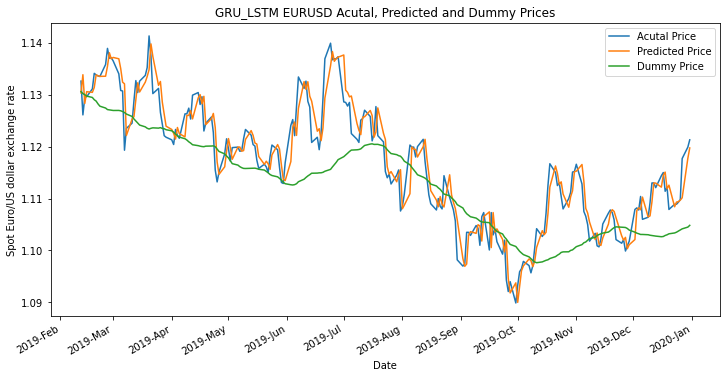

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

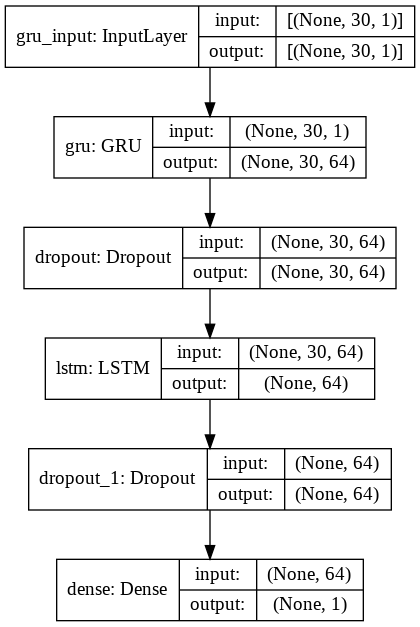

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.015028502083736637
RMSE:  0.12259079118651872
MAE:  0.10402346968275213
Dummy MSE:  0.0236885518332631
Dummy RMSE:  0.15391085677515767
Dummy MAE:  0.11970302826636056


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_EURUSD/assets
